In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Paths
dataset_csv = r"C:\Users\WALTON\Desktop\final-thesis\dataset\csv\final_dataset.csv"

In [7]:
# Parameters
batch_size = 32
image_size = (224, 224)
num_classes = 3
learning_rate = 1e-4
epochs = 30

In [8]:
# Load CSV and split data
df = pd.read_csv(dataset_csv)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

In [9]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 4730 validated image filenames belonging to 3 classes.
Found 1183 validated image filenames belonging to 3 classes.


In [10]:
# Build the Model
base_model = VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x) # Add another dropout layer
predictions = Dense(num_classes, activation="softmax")(x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [14]:
# Callbacks
checkpoint = ModelCheckpoint(
    "VGG19.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stopping, lr_scheduler]

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

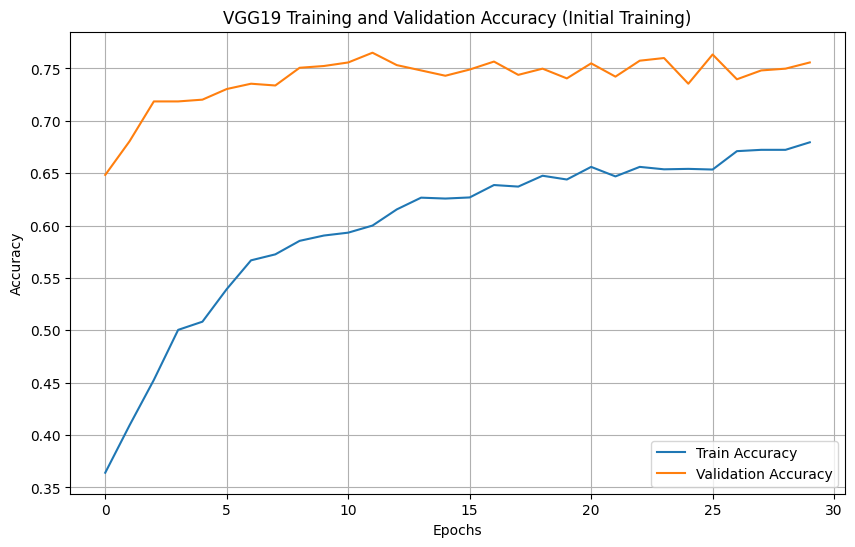

In [16]:
# Visualize Initial Training Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG19 Training and Validation Accuracy (Initial Training)')
plt.legend()
plt.grid()
plt.show()

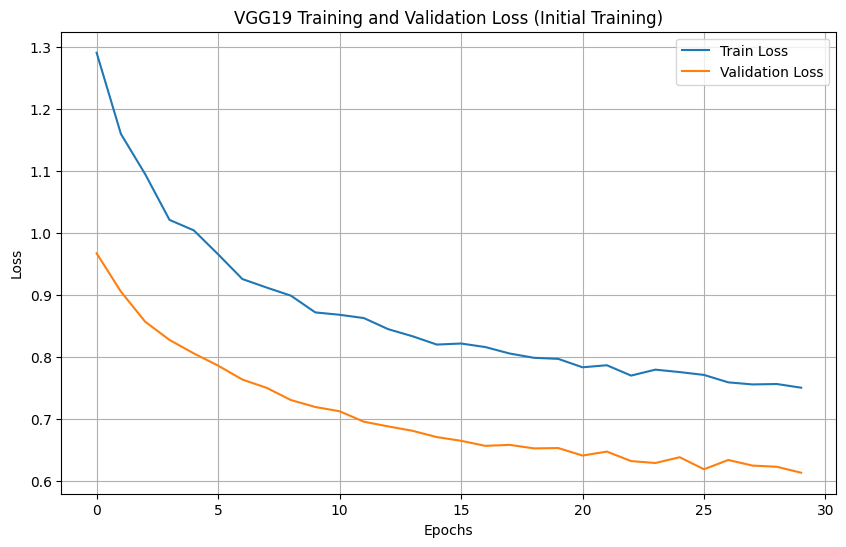

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('VGG19 Training and Validation Loss (Initial Training)')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Unfreeze and Fine-tune
for layer in base_model.layers:
    layer.trainable = True

In [19]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [20]:
# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs // 2,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5414s 37s/step - accuracy: 0.7503 - loss: 0.5849 - val_accuracy: 0.8681 - val_loss: 0.3385 - learning_rate: 1.0000e-05
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5362s 36s/step - accuracy: 0.8735 - loss: 0.3309 - val_accuracy: 0.8631 - val_loss: 0.3322 - learning_rate: 1.0000e-05
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5292s 36s/step - accuracy: 0.9067 - loss: 0.2442 - val_accuracy: 0.9019 - val_loss: 0.2599 - learning_rate: 1.0000e-05
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 4944s 33s/step - accuracy: 0.9193 - loss: 0.2202 - val_accuracy: 0.9062 - val_loss: 0.2672 - learning_rate: 1.0000e-05
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 4930s 33s/step - accuracy: 0.9244 - loss: 0.1935 - val_accuracy: 0.9146 - val_loss: 0.2140 - learning_rate: 1.0000e-05
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5185s 35s/step - accuracy: 0.9415 - loss: 0.1639 - val_accuracy: 0.8817 - val_loss: 0.2865 - learning_rate: 1.0000e-05
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5221s 

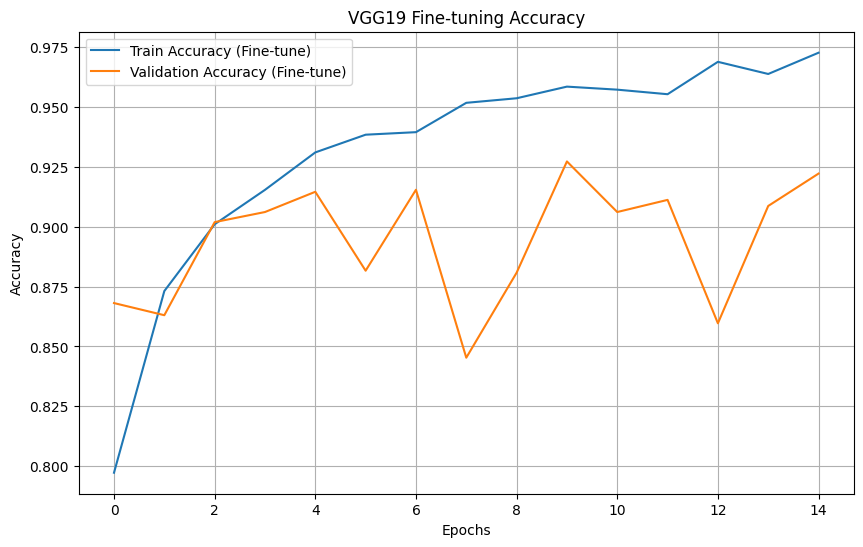

In [21]:
# Visualize Fine-tuning Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('VGG19 Fine-tuning Accuracy')
plt.legend()
plt.grid()
plt.show()

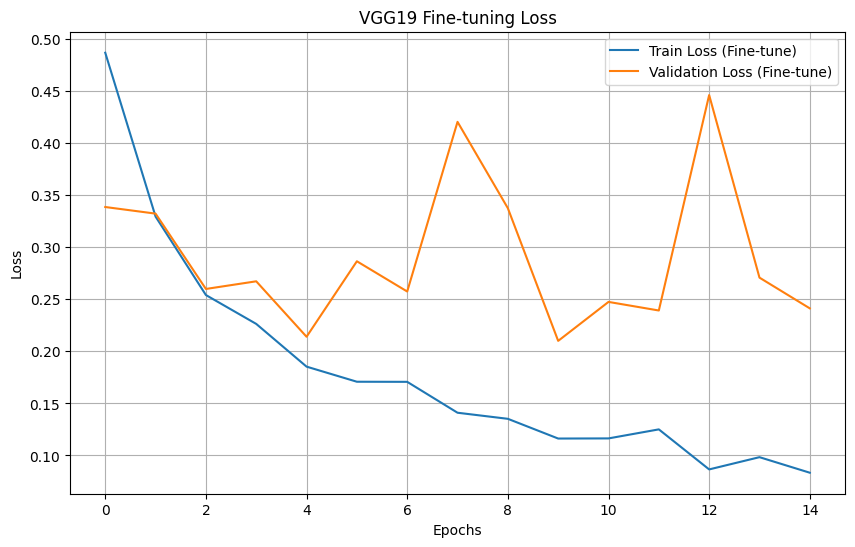

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('VGG19 Fine-tuning Loss')
plt.legend()
plt.grid()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 401s 11s/step


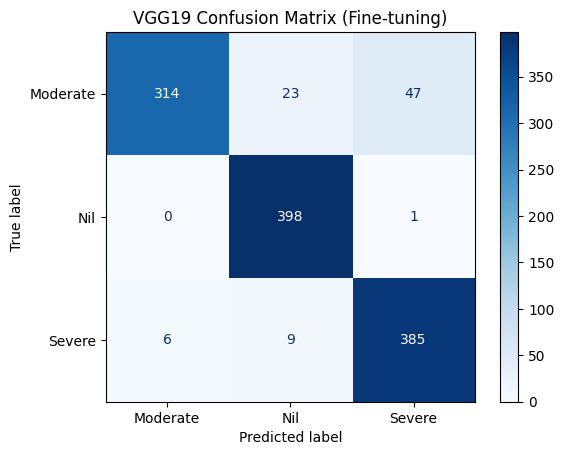

In [23]:
# Evaluation: Confusion Matrix and Classification Report 
val_predictions = np.argmax(model.predict(val_generator), axis=-1)
val_labels = val_generator.classes

cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('VGG19 Confusion Matrix (Fine-tuning)')
plt.show()

In [24]:
report = classification_report(val_labels, val_predictions, target_names=val_generator.class_indices.keys())
print("VGG19 Classification Report (Fine-tuning):\n", report)

VGG19 Classification Report (Fine-tuning):
               precision    recall  f1-score   support

    Moderate       0.98      0.82      0.89       384
         Nil       0.93      1.00      0.96       399
      Severe       0.89      0.96      0.92       400

    accuracy                           0.93      1183
   macro avg       0.93      0.93      0.93      1183
weighted avg       0.93      0.93      0.93      1183



In [25]:
# Save the Fine-tuned Model
model.save("VGG19_finetuned.keras")